# Práctica 3: Validación Cruzada 
Base de datos sobre el valor de un vehículo

###1.-Cargamos la base de tados de el repositorio de datos de UCI (https://archive.ics.uci.edu/ml/datasets.php)

In [0]:
# Librearias que siempre usamos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings # suprimir advertencias
warnings.filterwarnings('ignore')

# Librearias para cargar los datos desde una URL
import os
import requests

# Con esta función definimos como agrupar lod datos de acuerdo como se presentan en el repositorio
def load_dataset(path, urls):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        data = requests.get(url).content
        filename = os.path.join(path, os.path.basename(url))
        with open(filename, "wb") as file:
            file.write(data)
urls = ["https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names"]

# Cargamos los datos en la estructura datos. Aquellas celdas que tengan como valor '?', le ponemos NAN, porque luego es facil eliminarlos

load_dataset('data', urls)

datos = pd.read_csv('data/imports-85.data',
                            names=['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
                                   'num_doors', 'body_style', 'drive_wheels', 'engine_location',
                                   'wheel_base', 'length', 'width', 'height', 'curb_weight',
                                   'engine_type', 'num_cylinders', 'engine_size', 'fuel_system',
                                   'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm',
                                   'city_mpg', 'highway_mpg', 'price'], sep=r'\s*,\s*',
                            engine='python',
                            na_values="?")

### 2.- Eliminamos los valores con NAN y visualizamos os datos

In [39]:

datos = datos.dropna()
datos.describe()

symboling  normalized_losses  ...  highway_mpg         price
count  159.000000         159.000000  ...   159.000000    159.000000
mean     0.735849         121.132075  ...    32.081761  11445.729560
std      1.193086          35.651285  ...     6.459189   5877.856195
min     -2.000000          65.000000  ...    18.000000   5118.000000
25%      0.000000          94.000000  ...    28.000000   7372.000000
50%      1.000000         113.000000  ...    32.000000   9233.000000
75%      2.000000         148.000000  ...    37.000000  14719.500000
max      3.000000         256.000000  ...    54.000000  35056.000000

[8 rows x 16 columns]

###3.- Vamos a elegir solo una variable como caracteristica (x = horsepower) y como salida el precio (y)

Text(0, 0.5, 'Precio')

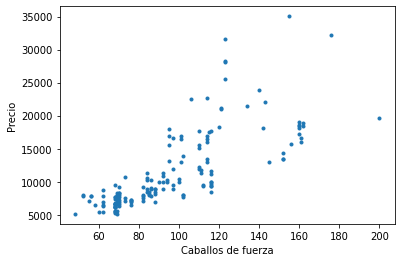

In [40]:

x = datos['horsepower']
y = datos['price']

plt.plot(x,y,'.')
plt.xlabel('Caballos de fuerza')
plt.ylabel('Precio')

###4.- Particionamos los datos en entrenamiento y test

Text(0, 0.5, 'Precio')

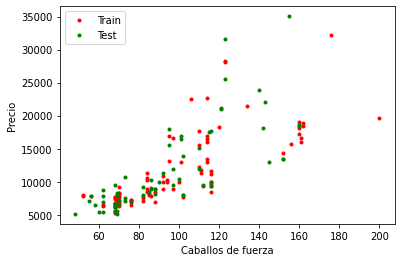

In [41]:
from sklearn.model_selection import train_test_split

x_tr, x_tst, y_tr, y_tst = train_test_split(x,y,test_size=0.4)


plt.plot(x_tr,y_tr,'r.',label='Train')
plt.plot(x_tst,y_tst,'g.',label='Test')
plt.legend()
plt.xlabel('Caballos de fuerza')
plt.ylabel('Precio')

###5.- Normalizamos los datos (asegurandose que se mantiene la forma de array)

In [42]:
from sklearn.preprocessing import StandardScaler

x_tr = np.array([np.array(x_tr)]).T
y_tr = np.array([np.array(y_tr)]).T
x_tst = np.array([np.array(x_tst)]).T
y_tst = np.array([np.array(y_tst)]).T

s=StandardScaler()
x_tr=s.fit_transform(x_tr)
x_tst=s.transform(x_tst)

np.shape(x_tr)

(95, 1)

### 6.- Configuramos el regresor lineal utilizando descenso de gradiente stocastisco

0.5583804141905484


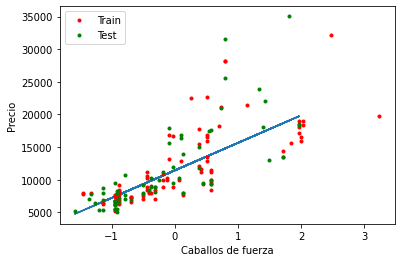

In [43]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
SGDreg = SGDRegressor(loss='squared_loss', penalty=None, learning_rate='adaptive',max_iter=1000)
SGDreg = SGDreg.fit(x_tr,y_tr)

y_tst_hat = SGDreg.predict(x_tst)
error = r2_score(y_tst,y_tst_hat)
plt.plot(x_tst,y_tst_hat)
plt.plot(x_tr,y_tr,'r.',label='Train')
plt.plot(x_tst,y_tst,'g.',label='Test')
plt.xlabel('Caballos de fuerza')
plt.ylabel('Precio')
plt.legend()
print(error)

###7.- Configuramos el regresor polinómico con el regresor lineal del paso 6

0.5567199877547014


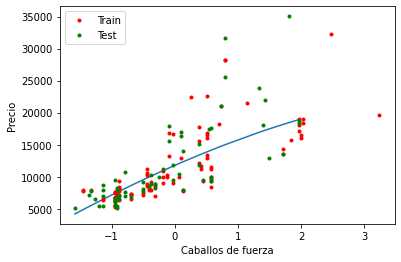

In [44]:
from sklearn.preprocessing import PolynomialFeatures

polyFeat = PolynomialFeatures(degree=3)
polyFeat = polyFeat.fit(x_tr,y_tr)
x_poly_tr = polyFeat.transform(np.array(x_tr))
x_poly_tst = polyFeat.transform(np.array(x_tst))
SGDreg = SGDreg.fit(x_poly_tr,y_tr)

y_tst_hat = SGDreg.predict(x_poly_tst)
error = r2_score(y_tst,y_tst_hat)
y_tst_hat = np.array([y_tst_hat]).T
# Ordenamos los datos solo para graficar
ind = np.argsort(x_tst, axis=0)
x_sort =np.take_along_axis(x_tst, ind, axis=0)
y_sort= np.take_along_axis(y_tst_hat, ind, axis=0)

plt.plot(x_sort,y_sort)
plt.plot(x_tr,y_tr,'r.',label='Train')
plt.plot(x_tst,y_tst,'g.',label='Test')
plt.xlabel('Caballos de fuerza')
plt.ylabel('Precio')
plt.legend()
print(error)

###8.- Ya tenemos todo listo para escoger el mejor modelo utilizando K-fold Cross Validation

Text(0.5, 1.0, 'Evolución del error de validación con el grado del polinómio')

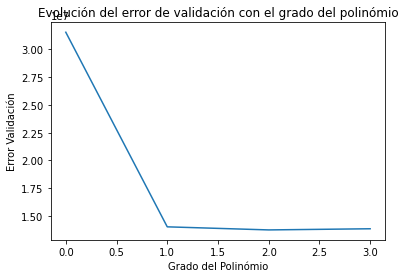

In [52]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Grado máximo del polinómio
grado = 4
# Número de particiones
fold = 5
# Array para el error de validacón para cada grado del polinómio
E_val = np.zeros(grado)


# Proceso de validación cruzada
crossvalidation = KFold(n_splits=fold, random_state=1, shuffle=False)

for i in range(0,grado):
    polyFeat = PolynomialFeatures(degree=i)
    polyFeat = polyFeat.fit(x_tr,y_tr)
    x_current = polyFeat.transform(x_tr)
    model = SGDreg.fit(x_current,y_tr)
    scores = cross_val_score(model, x_current, y_tr, scoring="neg_mean_squared_error", cv=crossvalidation, n_jobs=1)
    E_val[i] = np.mean(np.abs(scores)) # almacena la media del error para cada ejecución

#Graficamos el Error de validación, el mínimo error me dice el grado que consigue el modelo que generaliza el problema
plt.plot(E_val)
plt.xlabel('Grado del Polinómio')
plt.ylabel('Error Validación')
plt.title('Evolución del error de validación con el grado del polinómio')

###9.- Entrenamos el mejor modelo

0.5490371932230917


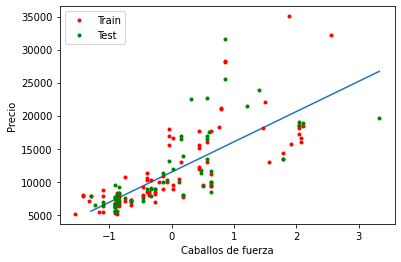

In [0]:
polyFeat = PolynomialFeatures(degree=1)
polyFeat = polyFeat.fit(x_tr,y_tr)
x_poly_tr = polyFeat.transform(np.array(x_tr))
x_poly_tst = polyFeat.transform(np.array(x_tst))
SGDreg = SGDreg.fit(x_poly_tr,y_tr)

y_tst_hat = SGDreg.predict(x_poly_tst)
error = r2_score(y_tst,y_tst_hat)
y_tst_hat = np.array([y_tst_hat]).T
# Ordenamos los datos solo para graficar
ind = np.argsort(x_tst, axis=0)
x_sort =np.take_along_axis(x_tst, ind, axis=0)
y_sort= np.take_along_axis(y_tst_hat, ind, axis=0)

plt.plot(x_sort,y_sort)
plt.plot(x_tr,y_tr,'r.',label='Train')
plt.plot(x_tst,y_tst,'g.',label='Test')
plt.xlabel('Caballos de fuerza')
plt.ylabel('Precio')
plt.legend()
print(error)